In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import date, datetime, timedelta
from sklearn.cluster import KMeans
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.simplefilter('ignore', category=Warning, lineno=0, append=False)

In [4]:
# import data
"import os"

# Assuming the file is in a subdirectory called 'data'
raw_df = pd.read_excel('data/Online_Retail.xlsx')
raw_df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Understand data structure
print(raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [6]:
raw_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
#Data Cleaning
# Drop 'Country' and 'InvoiceNo' columns
processed_df = raw_df.drop(['Country','Description'], axis=1)

# Remove rows with quantity less than or equal to zero
processed_df = processed_df[processed_df['Quantity'] >= 0]

# Remove rows with missing CustomerID
processed_df = processed_df.dropna(subset=['CustomerID'])

# Reset the index after removing rows
processed_df.reset_index(drop=True, inplace=True)

# Display the first few rows of the processed DataFrame
print(processed_df.head())

  InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice  CustomerID
0    536365    85123A         6 2010-12-01 08:26:00       2.55     17850.0
1    536365     71053         6 2010-12-01 08:26:00       3.39     17850.0
2    536365    84406B         8 2010-12-01 08:26:00       2.75     17850.0
3    536365    84029G         6 2010-12-01 08:26:00       3.39     17850.0
4    536365    84029E         6 2010-12-01 08:26:00       3.39     17850.0


In [8]:
#Data Processing
processed_df['Quantity'] = processed_df['Quantity'].astype(int)
processed_df['CustomerID'] = processed_df['CustomerID'].astype(str)
print(processed_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397924 entries, 0 to 397923
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Quantity     397924 non-null  int32         
 3   InvoiceDate  397924 non-null  datetime64[ns]
 4   UnitPrice    397924 non-null  float64       
 5   CustomerID   397924 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(3)
memory usage: 16.7+ MB
None


In [9]:
processed_df['Amount'] = processed_df['Quantity']*processed_df['UnitPrice']
rfm_ds_n = processed_df.groupby('CustomerID')['Amount'].sum()
rfm_ds_n.reset_index()
rfm_ds_n.columns = ['CustomerID', 'Amount']
print(rfm_ds_n)

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
             ...   
18280.0      180.60
18281.0       80.82
18282.0      178.05
18283.0     2094.88
18287.0     1837.28
Name: Amount, Length: 4339, dtype: float64


In [10]:
rfm_ds_f = processed_df.groupby('CustomerID')['InvoiceNo'].count()
rfm_ds_f = rfm_ds_f.reset_index()
rfm_ds_f.columns = ['CustomerID','Frequency']
print(rfm_ds_f)

     CustomerID  Frequency
0       12346.0          1
1       12347.0        182
2       12348.0         31
3       12349.0         73
4       12350.0         17
...         ...        ...
4334    18280.0         10
4335    18281.0          7
4336    18282.0         12
4337    18283.0        756
4338    18287.0         70

[4339 rows x 2 columns]


In [11]:
processed_df['InvoiceDate'] = pd.to_datetime(processed_df['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = max(processed_df['InvoiceDate'])
processed_df['Diff'] = max_date - processed_df['InvoiceDate']
rfm_ds_p = processed_df.groupby('CustomerID')['Diff'].min()
rfm_ds_p = rfm_ds_p.reset_index()
rfm_ds_p.columns = ['CustomerID', 'Diff']
rfm_ds_p['Diff'] = rfm_ds_p['Diff'].dt.days
print(rfm_ds_p)

     CustomerID  Diff
0       12346.0   325
1       12347.0     1
2       12348.0    74
3       12349.0    18
4       12350.0   309
...         ...   ...
4334    18280.0   277
4335    18281.0   180
4336    18282.0     7
4337    18283.0     3
4338    18287.0    42

[4339 rows x 2 columns]


In [12]:
rfm_ds_final = pd.merge(rfm_ds_n, rfm_ds_f, on='CustomerID',how='inner')
rfm_ds_final = pd.merge(rfm_ds_final, rfm_ds_p, on='CustomerID', how='inner')
rfm_ds_final.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
print(rfm_ds_final)

     CustomerID    Amount  Frequency  Recency
0       12346.0  77183.60          1      325
1       12347.0   4310.00        182        1
2       12348.0   1797.24         31       74
3       12349.0   1757.55         73       18
4       12350.0    334.40         17      309
...         ...       ...        ...      ...
4334    18280.0    180.60         10      277
4335    18281.0     80.82          7      180
4336    18282.0    178.05         12        7
4337    18283.0   2094.88        756        3
4338    18287.0   1837.28         70       42

[4339 rows x 4 columns]


In [13]:
rfm_ds_final.isnull().sum()

CustomerID    0
Amount        0
Frequency     0
Recency       0
dtype: int64

In [14]:
X = rfm_ds_final
X.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [15]:
n_clusters = range(2,8)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    # Build model
    model = make_pipeline(
        StandardScaler(), # clustering using distances - scaling is recommended
        KMeans(n_clusters=k, random_state=42)
    )
    # Train model
    model.fit(X)
    # Calculate inertia
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    # Calculate silhouette score
    silhouette_scores.append(
        silhouette_score(
            X, 
            model.named_steps["kmeans"].labels_)
    )

print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [13335.811759103894, 9789.84163670364, 7253.760092775041]

Silhouette Scores: [0.967907384506521, -0.054933315376663724, 0.06057916397339624]


In [16]:
import plotly.express as px
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x=n_clusters,
    y=inertia_errors,
    title="K-Means Model: Inertia vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")
fig.show()

In [17]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = fig = px.line(
    x=n_clusters,
    y=silhouette_scores,
    title="K-Means Model: Silhouette Score vs Number of Clusters (Elbow Method)"
)
fig.update_layout(
    xaxis_title="Number of Clusters", yaxis_title="Silhouette Score"
)
fig.show()

In [18]:
# final_model labels
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=3, random_state=42)
)
# Predict class labels
labels = final_model.fit_predict(X)
print(labels[:10])

[0 1 1 1 0 1 0 0 0 1]


In [19]:
X['labels'] = final_model.named_steps["kmeans"].labels_
print(labels[:10])

[0 1 1 1 0 1 0 0 0 1]


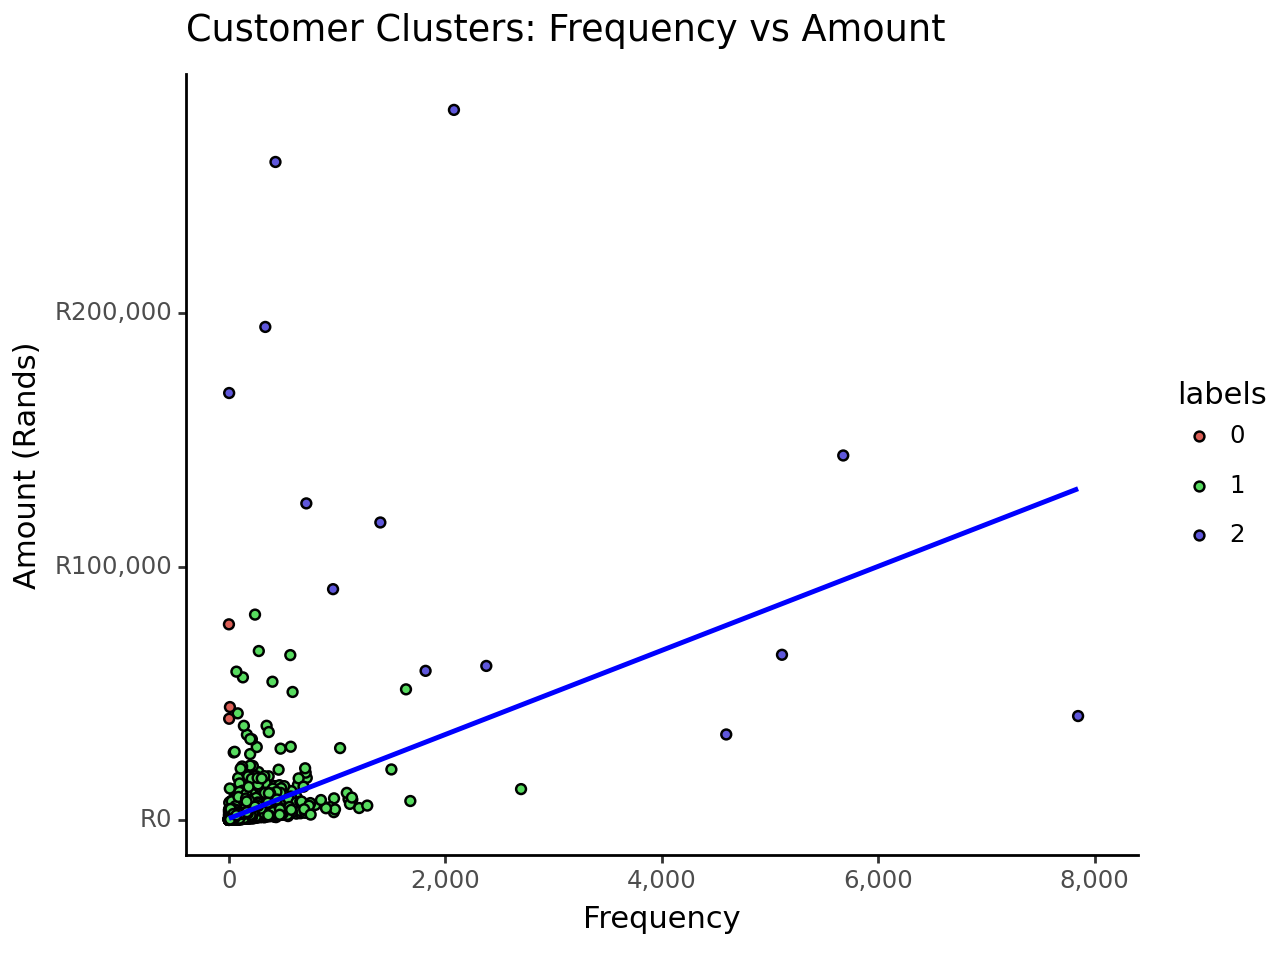

In [20]:
import plotnine as pn
from plotnine import *

# Create a plot area
p = (
    ggplot(X, aes(x='Frequency', y='Amount')) +
    # Add points into the plot area
    geom_point(aes(fill=X['labels'].astype(str))) +
    # Add a blue smooth line
    geom_smooth(color="blue", se=False) +
    # Format x-axis scale to display 'Frequency'
    scale_x_continuous(
        name='Frequency',
        labels=lambda x: [f'{x:,.0f}' for x in x],
        limits=(0, 8000)  # Adjust x-axis limits to zoom in
    ) +
    # Format y-axis scale to display 'Rands'
    scale_y_continuous(
        name='Amount (Rands)',
        labels=lambda y: [f'R{y:,.0f}' for y in y]
    ) +
    # Add title to the plot
    labs(title="Customer Clusters: Frequency vs Amount") +
    # Add plot theme
    theme_classic()
)

# Show the plot
print(p)


In [23]:
#Visualising the (PCA) values
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)
X_t
# # Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["Frequency", "Amount"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4339, 2)


,Frequency,Amount
0,75131.827933,-2750.800807
1,2265.160877,-2946.801551
2,-249.168049,-2952.663227
3,-288.330522,-2951.764055
4,-1712.391985,-2954.542898


In [25]:
# Create scatter plot
fig = px.scatter(
    data_frame=X_pca,
    x="Frequency",
    y="Amount",
    color=labels.astype(str),
    title="Customer Clusters: Frequency vs Amount"
)
fig.update_layout(xaxis_title="Frequency", 
                  yaxis_title="Amount")
fig.show()